In [1]:
using SpecialPolynomials
using LinearAlgebra
using SparseArrays
using Arpack
using ProgressMeter
using PyPlot


plt.rc("text", usetex = true)
plt.rc("text.latex", preamble = raw"\usepackage{amsmath} \usepackage{physics}")
plt.rc("axes", labelpad = 2)
plt.rc("legend", frameon = false)
plt.rc("font", size = 14)
plt.rc("axes", labelsize = 14)    # fontsize of the x and y labels
plt.rc("xtick", labelsize = 14)    # fontsize of the tick labels
plt.rc("ytick", labelsize = 14)    # fontsize of the tick labels
plt.rc("legend", fontsize = 12)

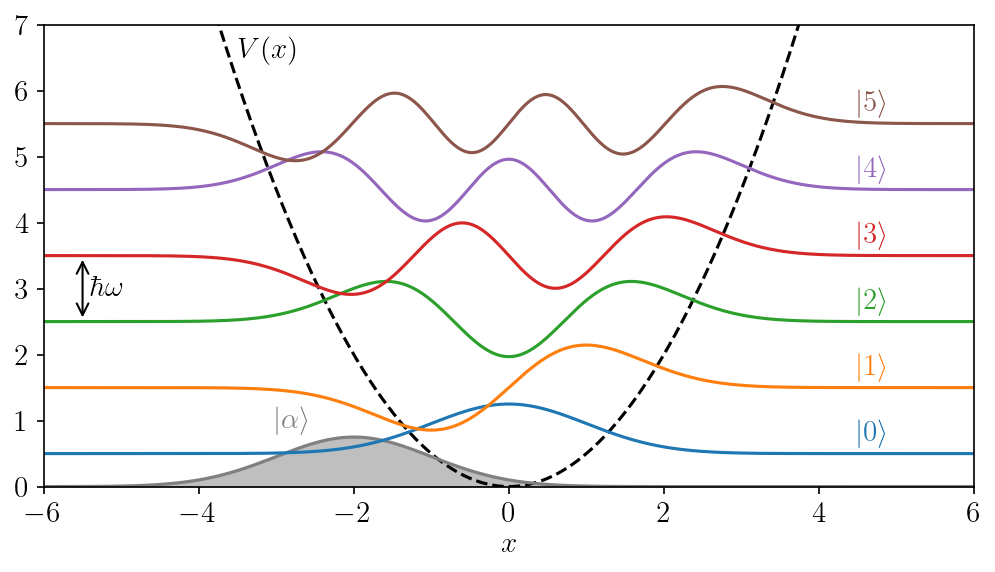

PyObject Text(-5.4, 3, '$\\hbar \\omega$')

In [2]:
m = 1
k = 1
ω = √(k/m)
α = -√(2) # Parameter of the coherent state

bounds = 6
x = range(-bounds, bounds, 1000)

# The Float64 is needed to avoid to create BigFloat when n is BigInt
ψ(n::Integer) = @. 1/√(2^n * factorial(n)) * (m*ω/π)^(1/4) * exp(-m*ω*x^2/2) * SpecialPolynomials.basis(Hermite, n)(x)

# Write down the first eigestates of the harmonic oscillator using the Hermite polynomials
ψₙ = [ψ(n) for n in 0:5]
Eₙ = [(n + 1/2) * ω for n in 0:5]

# coherent state wavefunction
ψ_coherent = @. (m*ω/π)^(1/4) * exp(-imag(α)^2) * exp(- (x - √(2) * α) .^ 2 / 2)

fig, ax = plt.subplots(dpi=150, figsize=(8, 4))

ax.plot(x, k/2 * x.^2, label=raw"$V(x)$", color = "black", ls="--")
ax.fill_between(x, ψ_coherent, color="grey", alpha=0.5)
ax.plot(x, ψ_coherent, color="grey", label="Coherent state")
ψ_plot = [ax.plot(x, ψₙ[i] .+ Eₙ[i], label="n = $i")[1] for i in eachindex(Eₙ)]
ax.set_xlim(x[1], x[end])
ax.set_ylim(0, 7)
ax.set_xlabel(raw"$x$")
for i in eachindex(Eₙ)
    # ax.text(4.5, Eₙ[i] + 0.2, raw"$\psi_" * string(i-1) * raw"$", color=ψ_plot[i].get_color())
    ax.text(4.5, Eₙ[i] + 0.2, raw"$\ket{" * string(i-1) * raw"}$", color=ψ_plot[i].get_color())
end
ax.text(-3.5, 6.5, raw"$V(x)$")
ax.text(-3, 0.9, raw"$\ket{\alpha}$", color="grey")
ax.annotate(raw"", xy=(-5.5,3.5), xytext=(-5.5,2.5), arrowprops=Dict(:arrowstyle => "<->"))
ax.text(-5.4, 3, raw"$\hbar \omega$", ha="left", va="center")
# plt.savefig("/mnt/c/Users/alber/OneDrive/Documents/GitHub/Latex-Projects/phd-thesis/figures/quantum_harmonic_oscillator.pdf", dpi=300, bbox_inches="tight")

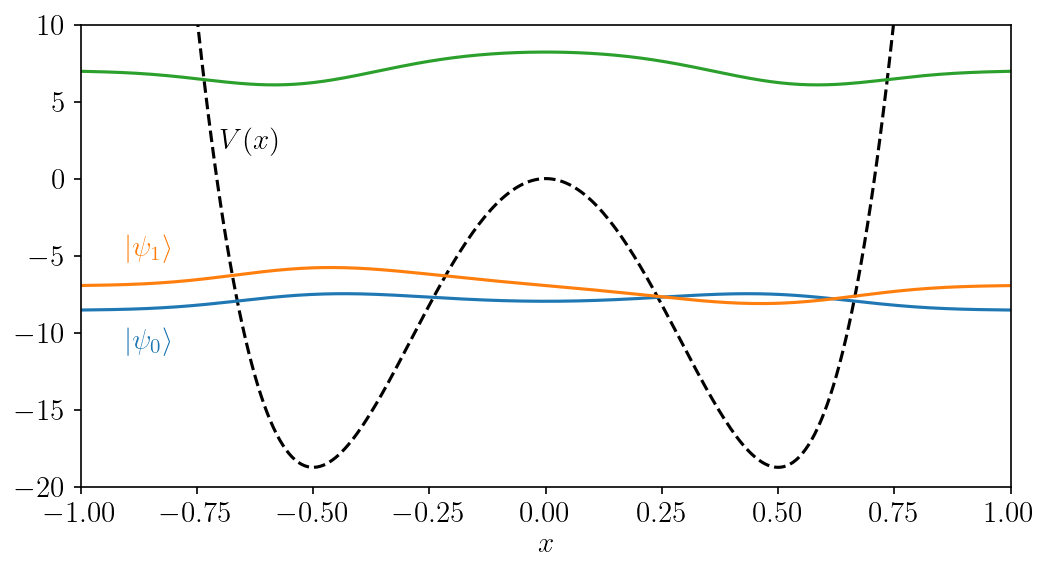

PyObject Text(0.5, 40.82896839488639, '$x$')

In [53]:
xbound = 1
Nx = 300
m = 1 # 7
α = 300 # 500
β = 150 # 130

x_l = range(-xbound, xbound, Nx)
dx = x_l[2] - x_l[1]

# Position operator
x = spdiagm(0 => ComplexF64.(x_l))

∂x = 1 / (2 * dx) * spdiagm(-1 => -ones(ComplexF64, Nx - 1), 1 => ones(Nx -1))
∂x2 = 1 / (dx^2) * spdiagm(-1 => ones(ComplexF64, Nx - 1), 0 => -2 * ones(Nx), 1 => ones(Nx -1))

V = α * x^4 - β * x^2

H = -∂x2 / (2*m) + V

# vals_DWP, vecs_DWP = eigen(Array(H))
vals_DWP, vecs_DWP = eigs(H, nev=8, sigma=minimum(real.(V)))
vals_DWP = real.(vals_DWP)
# The eigenvectors are defined up to a phase factor, since the Arpack algorithm starts with a random vector
# the results can change the sign of the eigenvectors. Here we fix this by multiplying the eigenvectors by the
# corresponding opposite phase factor of the maximum abs point in the left region of the state
x_neg_idxs = findall(x -> x < 0, x_l)
idx = findmax(abs2, vecs_DWP[x_neg_idxs, 1])[2]
vecs_DWP[:,1] .*= exp(-1im * angle(vecs_DWP[idx, 1]))
vecs_DWP[:,2] .*= exp(-1im * angle(vecs_DWP[idx, 2]))

# Make the states L2 normalized
ψ0 = vecs_DWP[:, 1] ./ √dx
ψ1 = vecs_DWP[:, 2] ./ √dx
ψ2 = vecs_DWP[:, 3] ./ √dx
ψ3 = vecs_DWP[:, 4] ./ √dx

fig, ax = plt.subplots(dpi=150, figsize=(8, 4))

ax.plot(x_l, real.(diag(V)), label=raw"$V(x)$", color = "black", ls="--")
ax.plot(x_l, real.(ψ0) .+ vals_DWP[1])
ax.plot(x_l, real.(ψ1) .+ vals_DWP[2])
ax.plot(x_l, real.(ψ2) .+ vals_DWP[3])
ax.plot(x_l, real.(ψ3) .+ vals_DWP[4])
ax.text(-0.7, 2, raw"$V(x)$")
ax.text(-0.9, -11, raw"$\ket{\psi_0}$", color="tab:blue")
ax.text(-0.9, -5, raw"$\ket{\psi_1}$", color="tab:orange")
ax.set_xlim(x_l[1], x_l[end])
ax.set_ylim(-20, 10)
ax.set_xlabel(raw"$x$")
# plt.savefig("/mnt/c/Users/alber/OneDrive/Documents/GitHub/Latex-Projects/phd-thesis/figures/double_well_potential.pdf", dpi=300, bbox_inches="tight")

In [38]:
function get_shifted_eigvals(H, nev, sigma)
    vals, vecs = eigs(H, nev=nev, sigma=sigma)
    return real.(vals .- vals[1])
end

function trunc_op(O, N)
    vecs = vecs_DWP[:,1:N]
    Op = sparse(vecs' * O * vecs)
    ishermitian(O) && return (Op + Op') / 2
    return Op
end

trunc_op (generic function with 1 method)

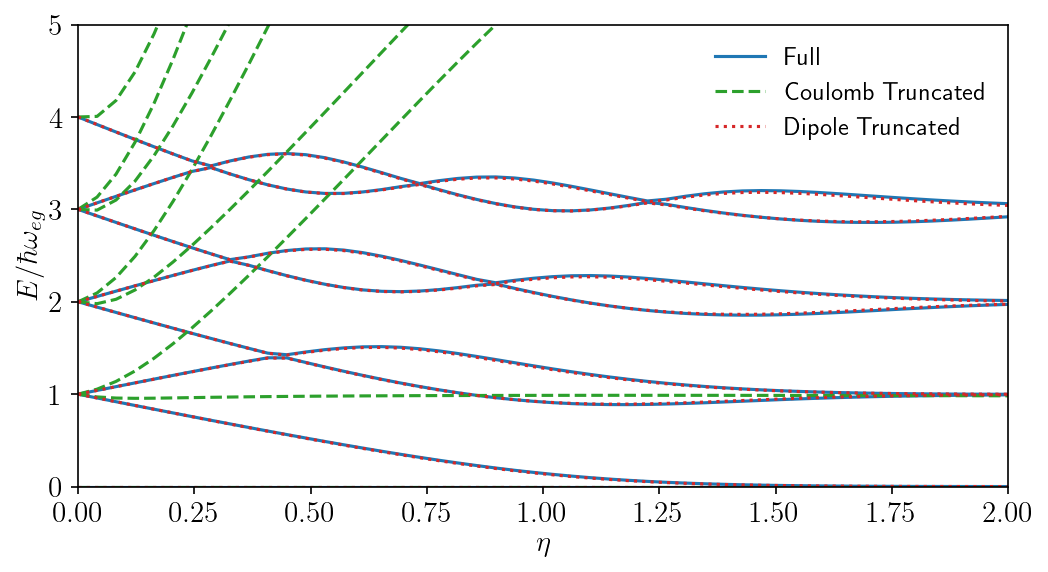

(0.0, 5.0)

In [62]:
Nc = 20

# Full Hilbert space in the Coulomb and dipole gauge
xbound = 1
Nx = 1000
m = 1
α = 400
β = 250
e = -1 # charge of the electron

# Define the atom subspace to calculate the atom eigestates
x_l = range(-xbound, xbound, Nx)
dx = x_l[2] - x_l[1]

x′ = spdiagm(0 => ComplexF64.(x_l))

∂x = 1 / (2 * dx) * spdiagm(-1 => -ones(ComplexF64, Nx - 1), 1 => ones(Nx -1))
p′ = 1im * ∂x

∂x2 = 1 / (dx^2) * spdiagm(-1 => ones(ComplexF64, Nx - 1), 0 => -2 * ones(Nx), 1 => ones(Nx -1))
p2′ = -∂x2

V′ = α * x′^4 - β * x′^2
Vmin = minimum(real.(V′))

H_atom = p2′ / (2*m) + V′
vals_DWP, vecs_DWP = eigs(H_atom, nev=8, sigma=minimum(real.(V)))
vals_DWP = real.(vals_DWP)
ωeg = vals_DWP[2] - vals_DWP[1]
xeg = abs(dot(vecs_DWP[:, 2], x′, vecs_DWP[:, 1]))
ωc = ωeg

# Hamiltonian in the full Hilbert space

a = kron(I(Nx), spdiagm(1 => sqrt.(1:Nc-1)))
x = kron(x′, I(Nc))
p = kron(p′, I(Nc))
p2 = kron(p2′, I(Nc))
V = kron(V′, I(Nc))

H_full_C(A0) = p2 / (2*m) + V + ωc * a' * a + e*A0/m * p * (a + a') + e^2 * A0^2 / (2*m) * (a + a')^2
H_full_D(A0) = p2 / (2*m) + V + ωc * a' * a + 1im * e*A0*ωc * x * (a - a') + e^2*A0^2*ωc*x^2

# Truncated Hilbert space
N_trunc = 2

a_tr = kron(I(N_trunc), spdiagm(1 => sqrt.(1:Nc-1)))
x_tr = kron(trunc_op(x′, N_trunc), I(Nc))
p_tr = kron(trunc_op(1im*∂x, N_trunc), I(Nc))
p2_tr = kron(trunc_op(-∂x2, N_trunc), I(Nc))
V_tr = kron(trunc_op(V′, N_trunc), I(Nc))


H_trunc_C(A0) = p2_tr / (2*m) + V_tr + ωc * a_tr' * a_tr + e*A0/m * p_tr * (a_tr + a_tr') + e^2 * A0^2 / (2*m) * (a_tr + a_tr')^2
H_trunc_D(A0) = p2_tr / (2*m) + V_tr + ωc * a_tr' * a_tr + 1im * e*A0*ωc * x_tr * (a_tr - a_tr') + e^2*A0^2*ωc*x_tr^2


# Calculate the eigenvalues
η_list = range(0, 2, 50)
neigs = 8

vals_full_C = similar(η_list, length(η_list), neigs)
vals_full_D = similar(vals_full_C)
vals_trunc_C = similar(vals_full_C)
vals_trunc_D = similar(vals_full_C)
prog = Progress(length(η_list), showspeed=true)
for i in eachindex(η_list)
    A0 = η_list[i] / (-e * xeg)
    vals_full_C[i,:] = get_shifted_eigvals(H_full_C(A0), 8, Vmin)
    vals_full_D[i,:] = get_shifted_eigvals(H_full_D(A0), 8, Vmin)
    vals_trunc_C[i,:] = get_shifted_eigvals(H_trunc_C(A0), 8, Vmin)
    vals_trunc_D[i,:] = get_shifted_eigvals(H_trunc_D(A0), 8, Vmin)
    next!(prog)
end

# Plot
fig, ax = plt.subplots(dpi=150, figsize=(8, 4))

# ax.plot(η_list, vals_full_C ./ ωeg, label=raw"Coulomb Full", color="tab:blue")
# ax.plot(η_list, vals_full_D ./ ωeg, label=raw"Dipole Full", color="tab:orange", ls="--")
# ax.plot(η_list, vals_trunc_C ./ ωeg, label=raw"Coulomb Truncated", color="tab:green", ls="--")
# ax.plot(η_list, vals_trunc_D ./ ωeg, label=raw"Dipole Truncated", color="tab:red", ls="-.")
ax.plot(η_list, vals_full_C[:,1] ./ ωeg, label=raw"Full", color="tab:blue")
ax.plot(η_list, vals_full_C[:,2:end] ./ ωeg, color="tab:blue")
ax.plot(η_list, vals_trunc_C[:,1] ./ ωeg, label=raw"Coulomb Truncated", color="tab:green", ls="--")
ax.plot(η_list, vals_trunc_C[:,2:end] ./ ωeg, color="tab:green", ls="--")
ax.plot(η_list, vals_trunc_D[:,1] ./ ωeg, label=raw"Dipole Truncated", color="tab:red", ls="-.")
ax.plot(η_list, vals_trunc_D[:,2:end] ./ ωeg, color="tab:red", ls="-.")
ax.legend()
ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$E / \hbar \omega_{eg}$")
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(0, 5)
plt.savefig("/home/alberto/OneDrive/Documents/GitHub/Latex-Projects/phd-thesis/figures/gauge_differences_double-well.pdf", dpi=300, bbox_inches="tight")